In [5]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

CIFAR_DIR = "./cifar-10-batches-py"
print(os.listdir(CIFAR_DIR))

['batches.meta', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'readme.html', 'test_batch']


<class 'dict'>
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
<class 'list'>
<class 'bytes'>
<class 'list'>
(10000, 3072)
[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]]
[6, 9]
b'training batch 1 of 5'
[b'leptodactylus_pentadactylus_s_000004.png', b'camion_s_000148.png']


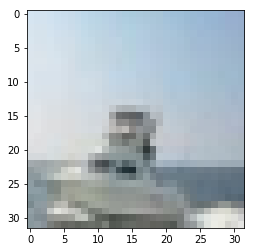

In [14]:
with open(os.path.join(CIFAR_DIR,"data_batch_1"),'rb') as f:
    data1 = pickle.load(f,encoding='bytes')
    print(type(data1))
    print(data1.keys())
    print(type(data1[b'labels']))
    print(type(data1[b'batch_label']))
    print(type(data1[b'filenames']))
    print(data1[b'data'].shape)
    print(data1[b'data'][0:2])
    print(data1[b'labels'][0:2])
    print(data1[b'batch_label'])
    print(data1[b'filenames'][0:2])
    image_arr = data1[b'data'][100]
#   解析三通道
    image_arr = image_arr.reshape((3,32,32))#32 32 3
# 通道交换
    image_arr = image_arr.transpose((1,2,0))

    %matplotlib inline
    plt.imshow(image_arr)

In [1]:
import tensorflow as tf
import os
import pickle 
import numpy as np

CIFAR_DIR = "./cifar-10-batches-py"
print(os.listdir(CIFAR_DIR))

['batches.meta', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'readme.html', 'test_batch']


In [2]:
def load_data(filename):
         with open(filename,'rb') as f:
            data = pickle.load(f,encoding="bytes")
            return data[b'data'],data[b'labels']
        
class CifarData:
     def __init__(self,filenames,need_shuffle):
            all_data = []
            all_labels = []
            for filename in filenames:
                data,labels = load_data(filename)
                for item,label in zip(data,labels):
                    if label in [0,1]:
                        all_data.append(item)
                        all_labels.append(label)
            self._data = np.vstack(all_data)
            self._data = self._data/127.5-1
            self._labels = np.hstack(all_labels)
            
            self._num_examples = self._data.shape[0]
            self._need_shuffle = need_shuffle
            self._indicator = 0
            if self._need_shuffle:
                 self._shuffle_data()
                    
     def _shuffle_data(self):
             p = np.random.permutation(self._num_examples)
             self._data = self._data[p]
             self._labels = self._labels[p]
            
     def next_batch(self,batch_size):
        end_indicator = self._indicator + batch_size
        if end_indicator > self._num_examples:
            if self._need_shuffle:
                self._shuffle_data()
                self._indicator = 0
                end_indicator = batch_size
            else:
                raise Exception("have no more examples")
        if end_indicator > self._num_examples:
            raise Exception("batch size is larger than all examples")
        batch_data = self._data[self._indicator:end_indicator]
        batch_labels = self._labels[self._indicator:end_indicator]
        self._indicator = end_indicator
        return batch_data,batch_labels



In [3]:
#计算图

x = tf.placeholder(tf.float32,[None,3072])
y = tf.placeholder(tf.int64,[None])

w = tf.get_variable('w',[x.get_shape()[-1],1],
initializer = tf.random_normal_initializer(0,1))

#(1,)
b = tf.get_variable('b',[1],
initializer = tf.constant_initializer(0.0))

y_=tf.matmul(x,w)+b

p_y_1 = tf.nn.sigmoid(y_) #变成概率值二分类
y_reshaped = tf.reshape(y,(-1,1))#将结果值变为一列
y_reshaped_float = tf.cast(y_reshaped,tf.float32)
loss = tf.reduce_mean(tf.square(y_reshaped_float - p_y_1))
predict = p_y_1 > 0.5
correct_prediction = tf.equal(tf.cast(predict,tf.int64),y_reshaped)
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float64))
with tf.name_scope('train'):
      train_op = tf.train.AdadeltaOptimizer(1e-3).minimize(loss)
        
train_filenames = [os.path.join(CIFAR_DIR,'data_batch_%d'% i) for i in range(1,6)]
test_data_filenames = [os.path.join(CIFAR_DIR,'test_batch')]
train_data = CifarData(train_filenames,True)
test_data = CifarData(test_data_filenames,False)

In [4]:
init = tf.global_variables_initializer()
batch_size = 20
train_steps = 100000

test_steps = 100

with tf.Session() as sess:
    sess.run(init)
    for i in range(train_steps):
        batch_data,batch_labels = train_data.next_batch(batch_size)
        loss_val,acc_val,_=sess.run(
            [loss,accuracy,train_op],
            feed_dict={
                x:batch_data,
                y:batch_labels
            }
        )
        if (i+1)%500==0:
            print('[Train] Step:%d,loss:%4.5f,acc:%4.5f'\
                 %(i+1,loss_val,acc_val))
        if(i+1)%5000 == 0:
            test_data = CifarData(test_data_filenames,False)
            all_test_acc_val =[]
            for j in range(test_steps):
                test_batch_data,test_batch_labels = test_data.next_batch(batch_size)
                test_acc_val = sess.run(
                    [accuracy],
                    feed_dict={
                        x:test_batch_data,
                        y:test_batch_labels
                    }
                )
                all_test_acc_val.append(test_acc_val)
            test_acc = np.mean(all_test_acc_val)
            print('Test Step:%d,acc:%4.5f'%(i+1,test_acc))

[Train] Step:500,loss:0.34997,acc:0.65000
[Train] Step:1000,loss:0.36682,acc:0.60000
[Train] Step:1500,loss:0.34727,acc:0.65000
[Train] Step:2000,loss:0.26150,acc:0.75000
[Train] Step:2500,loss:0.04978,acc:0.95000
[Train] Step:3000,loss:0.32831,acc:0.65000
[Train] Step:3500,loss:0.35032,acc:0.60000
[Train] Step:4000,loss:0.35507,acc:0.60000
[Train] Step:4500,loss:0.28811,acc:0.70000
[Train] Step:5000,loss:0.48586,acc:0.50000
Test Step:5000,acc:0.68900
[Train] Step:5500,loss:0.20345,acc:0.80000
[Train] Step:6000,loss:0.29905,acc:0.70000
[Train] Step:6500,loss:0.32606,acc:0.65000
[Train] Step:7000,loss:0.42801,acc:0.55000
[Train] Step:7500,loss:0.30013,acc:0.70000
[Train] Step:8000,loss:0.45380,acc:0.55000
[Train] Step:8500,loss:0.25004,acc:0.75000
[Train] Step:9000,loss:0.29914,acc:0.70000
[Train] Step:9500,loss:0.20118,acc:0.80000
[Train] Step:10000,loss:0.30514,acc:0.65000
Test Step:10000,acc:0.69100
[Train] Step:10500,loss:0.36156,acc:0.60000
[Train] Step:11000,loss:0.39530,acc:0.600

[Train] Step:88500,loss:0.24442,acc:0.70000
[Train] Step:89000,loss:0.47374,acc:0.50000
[Train] Step:89500,loss:0.26154,acc:0.75000
[Train] Step:90000,loss:0.41549,acc:0.60000
Test Step:90000,acc:0.69750
[Train] Step:90500,loss:0.17224,acc:0.80000
[Train] Step:91000,loss:0.09919,acc:0.90000
[Train] Step:91500,loss:0.36013,acc:0.65000
[Train] Step:92000,loss:0.41409,acc:0.55000
[Train] Step:92500,loss:0.40007,acc:0.60000
[Train] Step:93000,loss:0.00112,acc:1.00000
[Train] Step:93500,loss:0.24711,acc:0.75000
[Train] Step:94000,loss:0.14999,acc:0.85000
[Train] Step:94500,loss:0.38798,acc:0.60000
[Train] Step:95000,loss:0.39168,acc:0.60000
Test Step:95000,acc:0.69800
[Train] Step:95500,loss:0.24998,acc:0.75000
[Train] Step:96000,loss:0.39649,acc:0.60000
[Train] Step:96500,loss:0.30039,acc:0.70000
[Train] Step:97000,loss:0.39498,acc:0.60000
[Train] Step:97500,loss:0.26015,acc:0.70000
[Train] Step:98000,loss:0.20021,acc:0.80000
[Train] Step:98500,loss:0.25054,acc:0.75000
[Train] Step:99000,l

In [ ]:
import numpy as np

In [ ]:
a = [1,2]
b = [3,4]
c = np.vstack((a,b))
print(c)

In [ ]:
a = [[1,2],
     [3,4]]
b = [[5],
     [6]]
print(np.hstack([a,b]))